# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

In [44]:
## Import Libraries
import numpy as np

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA, KernelPCA
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, accuracy_score

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Used to save data into files
import pickle as pkl
import os

## The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

In [2]:
## Import train and test dataset, scale them and convert them to data loaders

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = len(train_dataset),
                          shuffle = False)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = len(test_dataset),
                          shuffle = False)

In [3]:
## Randomly select 10000 images from the training and test dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

idx = th.randperm(len(test_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

test_subset_loader = DataLoader(train_dataset, sampler=sampler)

In [4]:
## Convert the images and their labels to numpy arrays and reshape them to vectors

labels_subset = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch
    
    train_subset.append(data.numpy().reshape(1, -1))
    labels_subset.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_subset = np.array(labels_subset)

In [5]:
test_subset = []
labels_test = []

for batch in test_subset_loader:
    data, labels = batch
    
    test_subset.append(data.numpy().reshape(1, -1))
    labels_test.append(labels.numpy())

test_subset_scaled = np.array(test_subset).reshape(subset_size, -1)
labels_test = np.array(labels_test)

In [6]:
# Creating dictionary of labels for better understanding
description = {0: "T-shirt/top", 
               1: "Trouser", 
               2: "Pullover", 
               3: "Dress", 
               4: "Coat", 
               5: "Sandal", 
               6: "Shirt", 
               7: "Sneaker", 
               8: "Bag", 
               9: "Ankle boot"}


In [7]:
## Defining functions to save and load data from pickle files

def save_data(data, filename):
    if not os.path.exists(filename):
        with open(filename, "wb") as f:
            pkl.dump(data, f)

def load_data(filename):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            data = pkl.load(f)
    return data

## Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

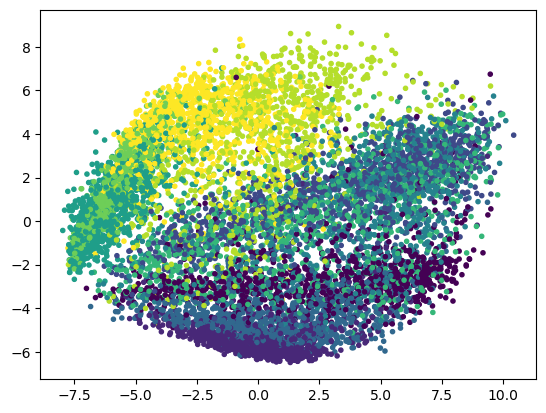

In [8]:
## Perform linear PCA and print its first 2 and 3 components


# ## Save data to files
# if os.path.exists("data_pca_linear.pickle"):
#      ## If the file exixts, load it
#     data_pca_linear = load_data("data_pca_linear.pickle")
    
# else:
#     ## If the file does not exixts, create it
    
model = PCA()
data_pca_linear = model.fit_transform(train_subset_scaled)
# save_data(data_pca_linear, "data_pca_linear.pickle")
        

plt.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], c = labels_subset, marker='.')

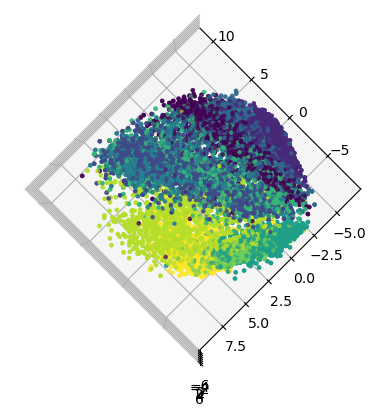

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], data_pca_linear[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=90, azim=135)

#### Comment
The data does not seem to be well separated, so finding the right hyperplane for classification will be hard.

### 1.2: Perform kernel PCA

In [10]:
## Perform kernel pca using the RBF kernel
# if os.path.exists("data_pca_rbf.pickle"):
#      ## If the file exixts, load it
#     data_pca_rbf = load_data("data_pca_rbf.pickle")
    
# else:
    ## If the file does not exixts, create it
    
kernel_pca = KernelPCA(kernel="rbf", n_components = 3)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

# save_data(data_pca_rbf, "data_pca_rbf.pickle")

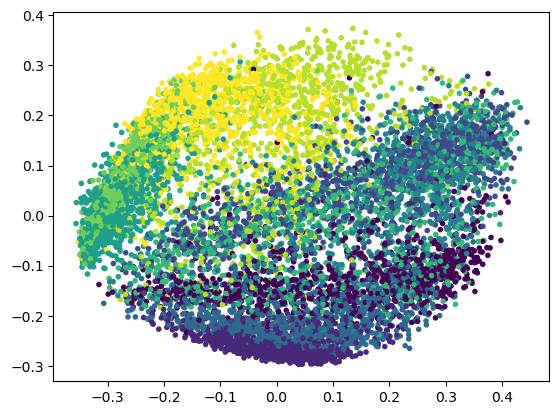

In [11]:
plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_subset, marker='.')

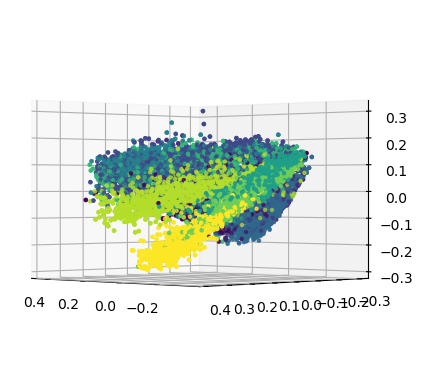

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], data_pca_rbf[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=0, azim=135)

### Perform parameter tuning

[0.         0.0002551  0.0005102  0.00076531 0.00102041 0.00127551
 0.00153061 0.00178571 0.00204082 0.00229592]


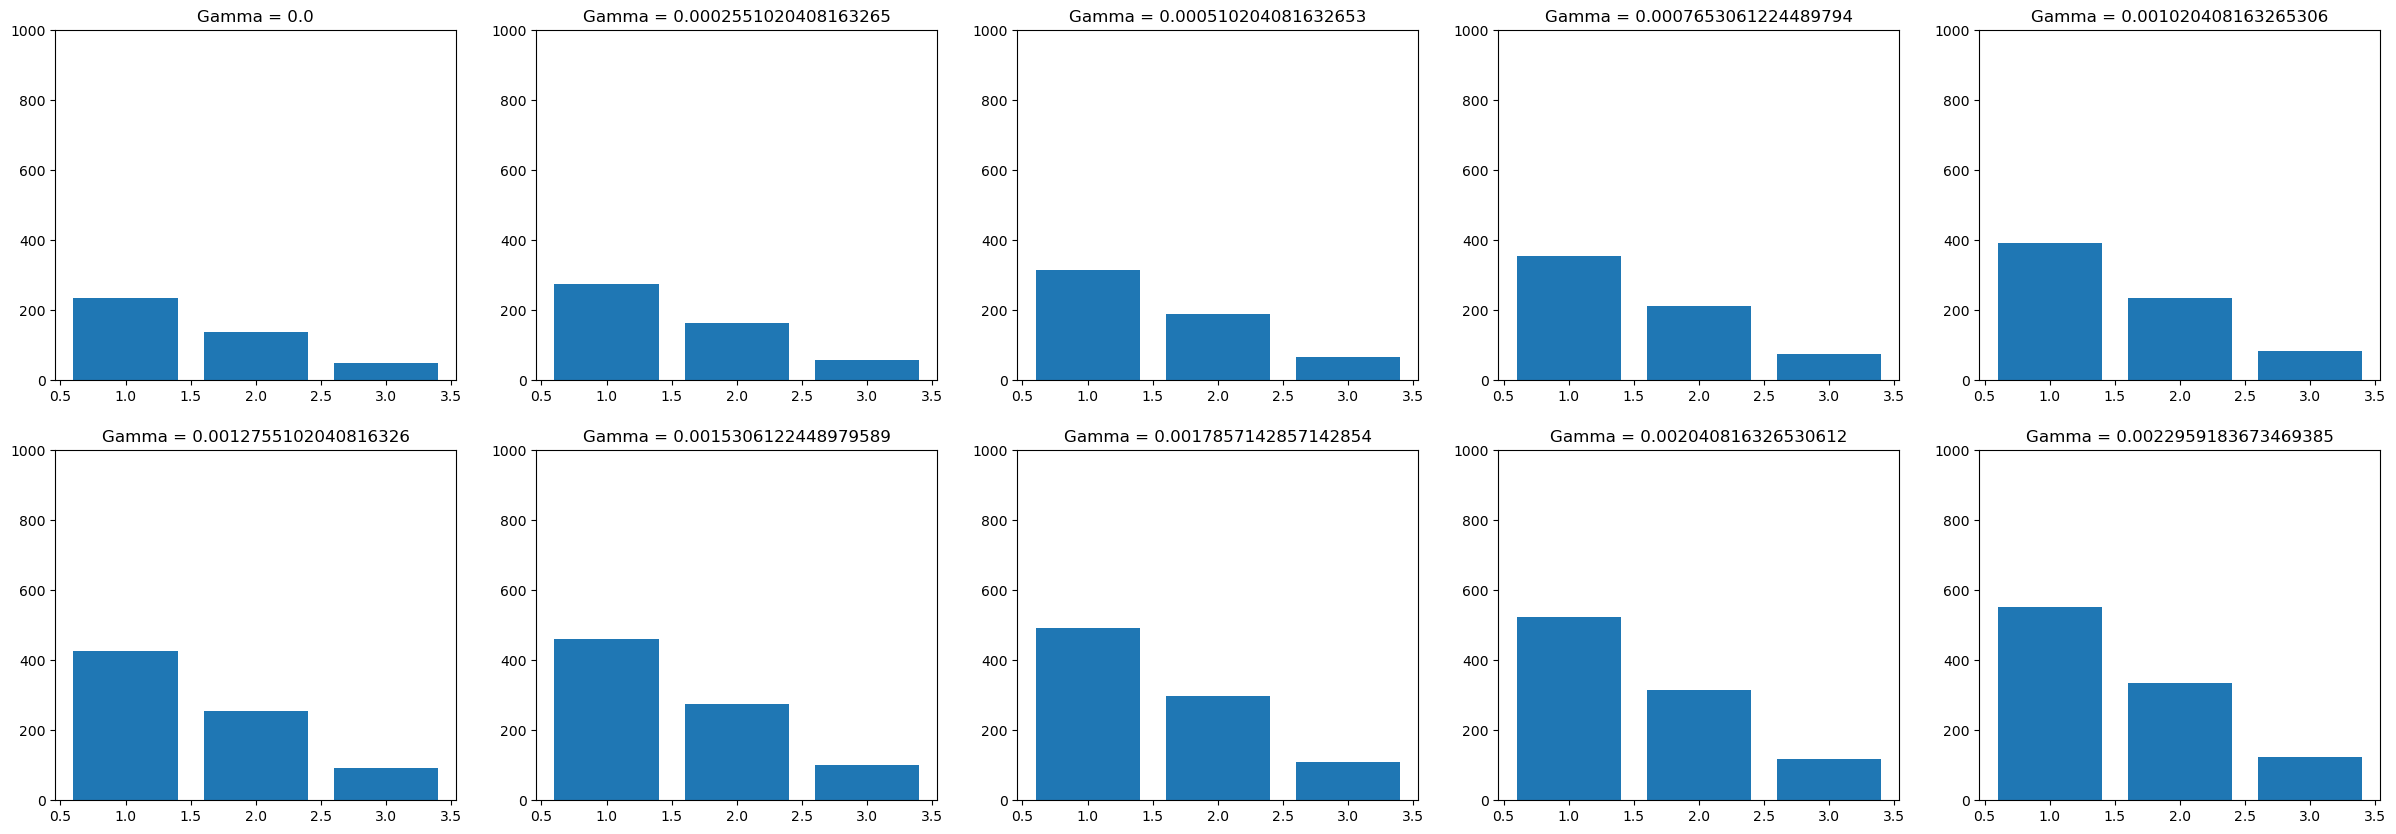

In [20]:
## Choose the range of the parameter gamma
gammas = np.arange(1/784 - 5 * (1/784) * (1/5), 1/784 + 5 * (1/784) * (1/5), (1/784) * (1/5))

print(gammas)

if os.path.exists("eigenvalues_rbf.pickle"):
     ## If the file exixts, load it
    eigenvalues_rbf = load_data("eigenvalues_rbf.pickle")
    
else:
    ## If the file does not exixts, create it

    ## Extract eigenvalues
    n_components = 3
    eigenvalues_rbf = np.empty((len(gammas), n_components))

    for i in range(len(gammas)):
        kernel_pca = KernelPCA(kernel="rbf", n_components = n_components, gamma = gammas[i])
        eigenvalues_rbf[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_
        
    save_data(eigenvalues_rbf, "eigenvalues_rbf.pickle")



# Plot the results
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

# Create 10 random plots
for i, ax in enumerate(axs.flat):
    # Generate random data
    x = np.arange(1, len(eigenvalues_rbf[i, :]) + 1, 1)
    # Plot the data on the corresponding axis
    ax.bar(x, eigenvalues_rbf[i, :])
    ax.set_ylim(0, 1000)
    # ax.set_xlabel('Component')
    # ax.set_ylabel('Eigenvalue')
    ax.set_title('Gamma = ' + str(gammas[i]))

### 1.3 Perform kPCA using another kernel

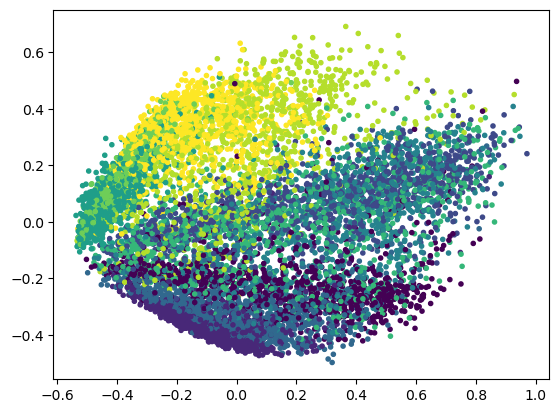

In [21]:
## Try kernel poly

if os.path.exists("data_pca_poly.pickle"):
     ## If the file exixts, load it
    data_pca_poly = load_data("data_pca_poly.pickle")
    
else:
    ## If the file does not exixts, create it
    
    kernel_pca = KernelPCA(kernel="poly", n_components = 3)

    data_pca_poly = kernel_pca.fit_transform(train_subset_scaled)
    
    save_data(data_pca_poly, "data_pca_poly.pickle")
    


plt.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], c = labels_subset, marker='.')

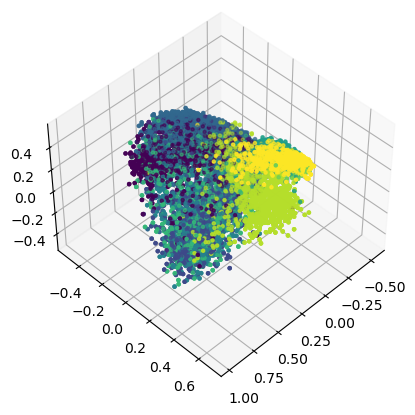

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], data_pca_poly[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=45, azim=45)

In [23]:
# degs = np.arange(1, 7, 1)

# n_components = 3
# eigenvalues = np.empty((len(degs), n_components))

# for i in range(len(degs)):
#     kernel_pca = KernelPCA(kernel="poly", n_components = n_components, degree = degs[i])
#     eigenvalues[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_

# # Create a figure and axis with 2 rows and 5 columns
# fig, axs = plt.subplots(2, 3, figsize=(30, 10))

# # Create 10 random plots
# for i, ax in enumerate(axs.flat):
#     # Generate random data
#     x = np.arange(1, len(eigenvalues[i, :]) + 1, 1)
#     # Plot the data on the corresponding axis
#     ax.bar(x, eigenvalues[i, :])
#     ax.set_ylim(0, 1000)
#     # ax.set_xlabel('Component')
#     # ax.set_ylabel('Eigenvalue')
#     ax.set_title('Degree = ' + str(degs[i]))

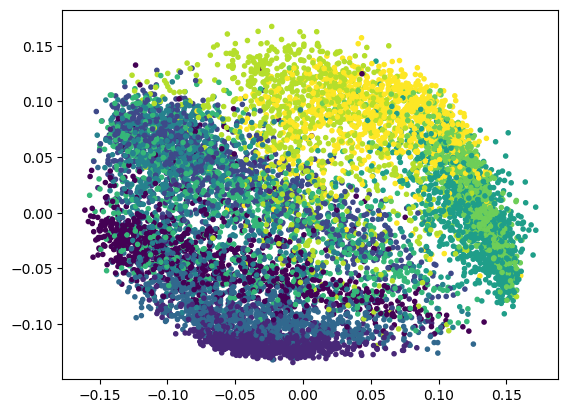

In [24]:
## Try kernel sigmoid

# if os.path.exists("data_pca_sigmoid.pickle") and os.path.exists("eigenvalues_sigmoid.pickle"):
    
#      ## If the file exixts, load it
#     data_pca_sigmoid = load_data("data_pca_sigmoid.pickle")
#     eigenvalues_sigmoid = load_data("eigenvalues_sigmoid.pickle")
    
# else:
    ## If the file does not exixts, create it
    
kernel_pca = KernelPCA(kernel="sigmoid", n_components = 10)

data_pca_sigmoid = kernel_pca.fit_transform(train_subset_scaled)

# save_data(data_pca_sigmoid, "data_pca_sigmoid.pickle")

eigenvalues_sigmoid = kernel_pca.eigenvalues_

# save_data(eigenvalues_sigmoid, "eigenvalues_sigmoid.pickle")

plt.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels_subset, marker='.')

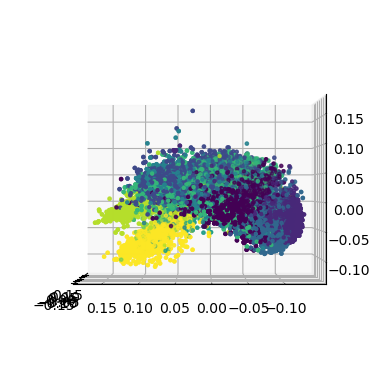

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], data_pca_sigmoid[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=0, azim=180)

## Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

In [26]:
labels_Kmeans = KMeans(n_clusters = 10).fit(data_pca_sigmoid).labels_

labels_Spectral = SpectralClustering(n_clusters = 10, affinity='nearest_neighbors').fit(data_pca_sigmoid).labels_

labels_Gaussian = GaussianMixture(n_components = 10).fit(data_pca_sigmoid).predict(data_pca_sigmoid)

labels = np.array([labels_subset.reshape(subset_size), labels_Kmeans, labels_Spectral, labels_Gaussian])

/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


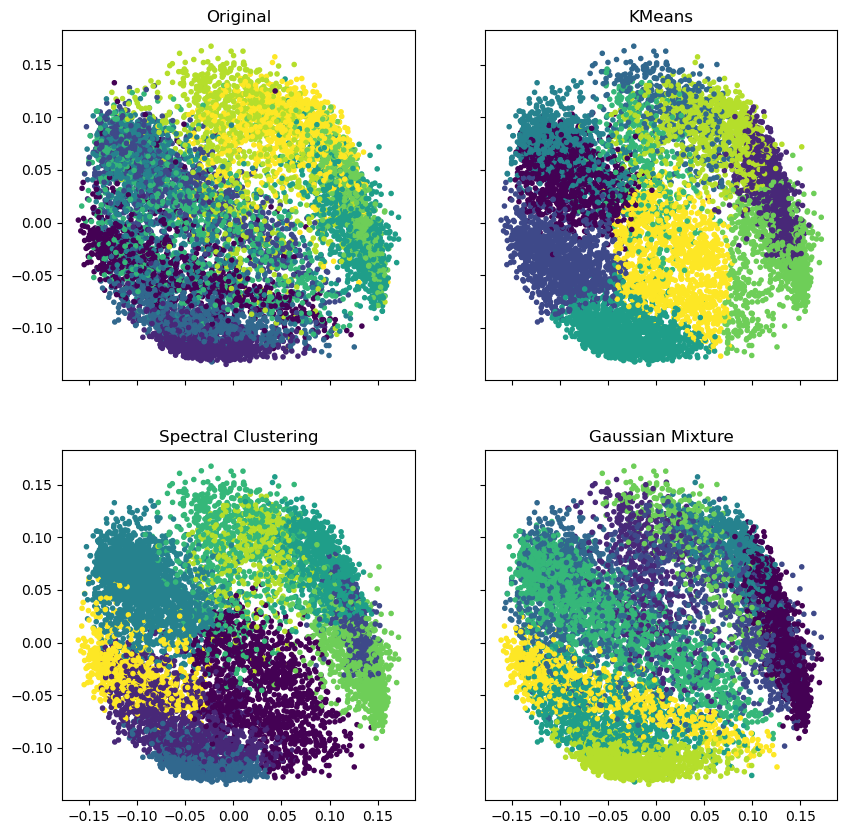

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

title_names = ["Original", "KMeans", "Spectral Clustering", "Gaussian Mixture"]

for ax, i in zip(axs.flat, range(4)):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels[i, :], marker='.')
    ax.set_title(title_names[i])

In [28]:
## Adjusted Rand Index

ARI = np.empty(3)

for i in range(3):
    ARI[i] = adjusted_rand_score(labels[0, :], labels[i + 1, :])
    print("Adjusted Rand Index for " + title_names[i + 1] + ": " + str(ARI[i]))

Adjusted Rand Index for KMeans: 0.3839059948698334
Adjusted Rand Index for Spectral Clustering: 0.43416408539993234
Adjusted Rand Index for Gaussian Mixture: 0.41000104122003705


#### a
As we can see, label assignment performed poorly. This, probably, because the clusters are very close to each other and not clearly separated.

#### b
As we can see from the plot below, there is a clear elbow on the third component. This suggests that 10 does not reflect the actual knee point of the spectrum of the principal components.

Text(0, 0.5, 'Eigenvalue')

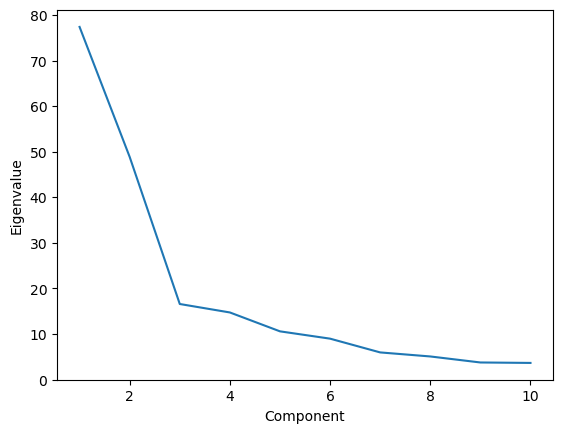

In [29]:
plt.plot(np.arange(1, len(eigenvalues_sigmoid) + 1, 1), eigenvalues_sigmoid)

plt.xlabel('Component')
plt.ylabel('Eigenvalue')

## Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

3.1

In [48]:
# Gridsearch SVM
param_grid = {"kernel": ["linear", "poly", "rbf", "sigmoid"]}
svm = SVC()
classifier = GridSearchCV(svm, param_grid, cv=5)
classifier.fit(
    data_pca_sigmoid, labels_Gaussian
)  # X is your feature matrix, y is your target variable
print(classifier.cv_results_)

{'mean_fit_time': array([0.59318976, 0.24143066, 0.23713651, 0.55074415]), 'std_fit_time': array([0.01899265, 0.00121066, 0.00401221, 0.03373202]), 'mean_score_time': array([0.27433786, 0.1351182 , 0.21614041, 0.32616768]), 'std_score_time': array([0.00119567, 0.00054649, 0.0022214 , 0.00668746]), 'param_kernel': masked_array(data=['linear', 'poly', 'rbf', 'sigmoid'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'kernel': 'linear'}, {'kernel': 'poly'}, {'kernel': 'rbf'}, {'kernel': 'sigmoid'}], 'split0_test_score': array([0.857, 0.921, 0.934, 0.749]), 'split1_test_score': array([0.8525, 0.921 , 0.9345, 0.713 ]), 'split2_test_score': array([0.85  , 0.9005, 0.9215, 0.7135]), 'split3_test_score': array([0.85  , 0.9175, 0.9275, 0.7405]), 'split4_test_score': array([0.845 , 0.9005, 0.9205, 0.713 ]), 'mean_test_score': array([0.8509, 0.9121, 0.9276, 0.7258]), 'std_test_score': array([0.00390384, 0.0095572 , 0.00593633, 0.015705

In [31]:
data = TensorDataset(Tensor(data_pca_sigmoid), Tensor(labels_Gaussian))

data_loader = DataLoader(dataset = data, batch_size=64, shuffle=True)

In [25]:
data_pca_sigmoid.shape

(10000, 10)

3.2

In [49]:
# Model definition
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc = nn.Linear(in_features= 28 * 28, out_features=10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)  # More numerically stable than softmax
        return x

In [51]:
# Model instantiation
model = FCNN()

EPOCHS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.0

# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

optimizer = th.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

criterion = nn.NLLLoss()

Using device: cpu


In [52]:
# Some useful functions
def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [53]:
# Get test stats before training
model = model.eval()
untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)
model = model.train()

In [ ]:
# Training loop

batch_losses = []

for epoch in trange(EPOCHS):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

# Saving weights
dirname = "models/"
if not os.path.exists(dirname):
    os.makedirs(dirname)
th.save(model.state_dict(), dirname + "rotation_invariant_slfcn.pth")

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [26]:
#Importing the dataset again

subset_size = 64

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset, shuffle=True, batch_size = subset_size)
test_loader = DataLoader(dataset = test_dataset, shuffle=True, batch_size = subset_size)

In [27]:
# def imshow(img):
#     npimg = img.numpy()
#     plt.axis("off")
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# dataiter = train_loader.__iter__()
# images, labels = dataiter.__next__()

# imshow(torchvision.utils.make_grid(images))

In [28]:
# Some useful functions
def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc
    
def hinge_loss(y_pred, y_true):
    return th.mean(th.clamp(1 - y_pred.t() * y_true, min=0))

In [29]:
def train_model(epochs, train_loader, test_loader, criterion, optimizer, device, model):
    _batch_losses = []

    for _ in trange(epochs):
        _model = model.train()

        # Actual (batch-wise) training step
        for _, (_images, _labels) in enumerate(train_loader):
            _images = _images.to(device)
            _labels = _labels.to(device)

            _logits = _model(_images)
            _loss = criterion(_logits, _labels)

            _batch_losses.append(_loss.item())  # Store the loss for plotting, per batch

            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()

        _model.eval()
        
    _trained_loss, _trained_acc = get_test_stats(_model, criterion, test_loader, device)

    print(f"Accuracy: {_trained_acc} | Loss: {_trained_loss}")
    
    return _trained_acc, _trained_loss, _model, _batch_losses

Implementing linear and rbf SVM and confronting it with the sklearn implementation

In [30]:
class LinearSVM(nn.Module):
    def __init__(self, n_classes, image_size):
        super(LinearSVM, self).__init__()

        self._linear = nn.Linear(image_size, n_classes)
            
        
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self._linear(x)
        x = F.log_softmax(x, dim = 1)
        return x


model = LinearSVM(n_classes = 10, image_size = 28 * 28)


In [31]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# criterion = nn.CrossEntropyLoss()

criterion = nn.NLLLoss()

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)


model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

trained_acc, trained_loss, model, batch_losses = train_model(epochs = 3,
                                                             train_loader = train_loader,
                                                             test_loader = test_loader,
                                                             criterion = criterion,
                                                             optimizer = optimizer,
                                                             device = device,
                                                             model = model)
print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

Using device: cpu
Untrained test loss: 2.3556, accuracy: 20.31%


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:36<00:00, 12.03s/it]

Accuracy: 71.875 | Loss: 0.6987439393997192
Accuracy: 71.875 | Loss: 0.6987439393997192


In [32]:
classifier = SVC(kernel = "linear").fit(train_subset_scaled, labels_subset)

label_predict = classifier.predict(test_subset_scaled)
accuracy_score(labels_test, label_predict)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8524

In [33]:
class RBF_SVM(nn.Module):
    def __init__(self, gamma_init, n_classes, image_size):
        super(RBF_SVM, self).__init__()
        self._gamma = nn.Parameter(th.FloatTensor(gamma_init), requires_grad = True)
        # self._bias = nn.Parameter(th.zeros(1, n_classes))
        self._support_vectors = nn.Parameter(th.randn(image_size, n_classes))
    
    def rbf_kernel(self, x):
        diff = x[:, None, :] - self._support_vectors.t()[None, :, :]
        return th.exp(-self._gamma * (diff ** 2).sum( dim = 2))
        
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.rbf_kernel(x)
        x = F.log_softmax(x, dim = 1)
        return x
    
model = RBF_SVM(gamma_init = 1, n_classes = 10, image_size = 28 * 28)

In [34]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# criterion = nn.CrossEntropyLoss()

criterion = nn.NLLLoss()

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)


model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

trained_acc, trained_loss, model, batch_losses = train_model(epochs = 3,
                                                             train_loader = train_loader,
                                                             test_loader = test_loader,
                                                             criterion = criterion,
                                                             optimizer = optimizer,
                                                             device = device,
                                                             model = model)
print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

Using device: cpu
Untrained test loss: 2.3026, accuracy: 9.38%


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:46<00:00, 15.40s/it]

Accuracy: 4.6875 | Loss: 2.3025851249694824
Accuracy: 4.6875 | Loss: 2.3025851249694824


In [35]:
classifier = SVC(kernel = "rbf").fit(train_subset_scaled, labels_subset)

label_predict = classifier.predict(test_subset_scaled)
accuracy_score(labels_test, label_predict)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8716

#### 3.2: Fully Connected NN

In [36]:
class FullyConnectedNN(nn.Module):
    def __init__(self, image_dim, n_classes):
        
        super(FullyConnectedNN, self).__init__()
        
        self.fc = nn.Linear(in_features = image_dim,
                            out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [37]:
model = FullyConnectedNN(image_dim = 28 * 28, n_classes = 10)

# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

criterion = nn.NLLLoss()

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

Using device: cpu


In [38]:
model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

Untrained test loss: 2.3201, accuracy: 10.94%


In [42]:
batch_losses = []

for epoch in trange(2):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

100%|██████████| 2/2 [00:20<00:00, 10.48s/it]


In [43]:
# Get test stats after training
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)

print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

Accuracy: 84.375 | Loss: 0.5487431287765503


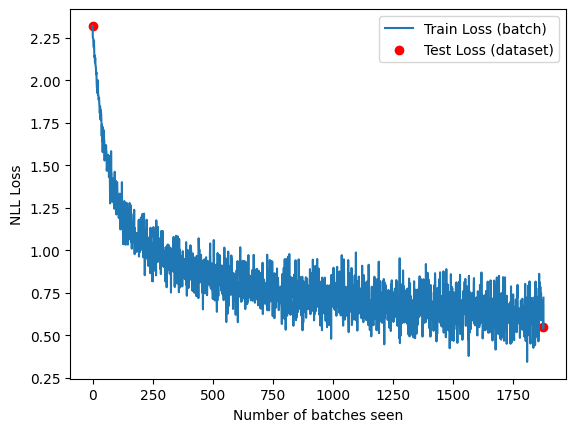

In [44]:
# Plot losses
xrange = range(len(batch_losses))
_ = plt.plot(xrange, batch_losses)
_ = plt.scatter((xrange[0], xrange[-1]), (untrained_loss, trained_loss), color="red")
_ = plt.legend(["Train Loss (batch)", "Test Loss (dataset)"], loc="upper right")
_ = plt.xlabel("Number of batches seen")
_ = plt.ylabel("NLL Loss")

#### 3.2: Convolutional NN

In [45]:
class CNN(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size, layers, pooling):
        super(CNN, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
        self._print_dimensions = False
        
        self._layers = layers
        
        self._pooling = pooling
        
        if self._layers >= 1:   
            self.conv1, self.bn1, self._dimensions = self.conv_layer(self._kernel)
         
        if self._layers >= 2:
            self.conv2, self.bn2, self._dimensions = self.conv_layer(self._kernel)
            
        if self._pooling == True:
            self.pool = nn.MaxPool2d(kernel_size = self._kernel, stride = self._stride)
            if self._print_dimensions == True:
                print("Defined pool")
        
            self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - self._kernel) * self._stride_inv + 1,
                                (self._dimensions[3] - self._kernel) * self._stride_inv + 1
                                ]
        
        if self._layers >= 3: 
            self.conv3, self.bn3, self._dimensions = self.conv_layer(self._kernel)
            
        
        if self._layers >= 4: 
            self.conv4, self.bn4, self._dimensions = self.conv_layer(self._kernel)
        
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
        if self._print_dimensions == True:
            print("Defined fc1")
            
    def conv_layer(self, kernel_size):
        conv = nn.Conv2d(in_channels = self._dimensions[1], out_channels = self._dimensions[1], kernel_size = kernel_size)
        
        dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        bn = nn.BatchNorm2d(self._dimensions[1])
        
        return conv, bn, dimensions
    
    
    

    def apply_conv_layer(self, input, conv, bn):
        output = conv(input)
        output = bn(output) 
        output = F.relu(output)
        
        return output 
    
        
    def forward(self, input):
        
        if self._print_dimensions == True:
            print(f"Input size: {input.size()}")
            
        output = input
        
        if self._layers >= 1: 
            output = self.apply_conv_layer(output, self.conv1, self.bn1) 
        
        if self._layers >= 2:
            output = self.apply_conv_layer(output, self.conv2, self.bn2) 
        
        
        if self._pooling == True:
            output = self.pool(output)    
            if self._print_dimensions == True:
                print(f"Applied pool, size: {output.size()}")
        
        
        if self._layers >= 3:
            output = self.apply_conv_layer(output, self.conv3, self.bn3) 
        
        
        if self._layers >= 4:
            output = self.apply_conv_layer(output, self.conv4, self.bn4) 
        

        output = output.view(output.shape[0], -1)
        if self._print_dimensions == True:
            print(f"Applied view, size: {output.size()}")
        
        output = self.fc1(output)
        
        if self._print_dimensions == True:
            print(f"Applied fc1, size: {output.size()}") 
        
        
        return output


In [46]:
# Device selection
model = CNN(n_classes = 10, kernel_size = 2, input_size = images.shape, layers = 4, pooling = True)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

# optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

Using device: cpu
Untrained test loss: 2.2997, accuracy: 17.19%


In [47]:
batch_losses = []
EPOCHS = 2

for epoch in trange(EPOCHS):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:42<00:00, 21.27s/it]


In [48]:
# Get test stats after training
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)

print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

Accuracy: 73.4375 | Loss: 0.7416539192199707
